In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import math

## Intro

Task 1.  
H0: Distribution is statistically the same as the given one.  
H1: Distribution is statistically significantly different from the given one.  

Task 2.  
When X - categorical, y - categorical  
H0: There is NO significant difference between 'y' from different X groups  
H1: There is a significant difference between 'y' from different X groups  
In other words:  
H0: There is NO significant difference in quantities of categories in two or more gorups  
H1: There is a significant difference in quantities of categories in two or more gorups

Task 1 and Task 2 are also called **odds ratio** tests. There are 3 methods that can do it:
1. Chi-squared test
2. Fisher's exact test
3. Wald test

Task 3.  
When X is a mixed variable, y - categirical  
H0: X does NOT influence 'y' ($\beta_i = 0$)  
H1: X has stasistically significant influence on 'y' ($\beta_i \neq 0$)  

Task 3 can be done by Logistic Regression

Topics:  
Pearson's (chi-squared) distance  
Chi-squared distribution  
Pearson's chi-square criterion  

Pearson's (chi-squared) distance

$\chi^2 = \sum_{i=1}^{n}Z_i = \sum_{i=1}^{n}\frac{(O_i - E_i)^2}{E_i}$

where $Z_i, ..., Z_n$ are independend standard normal random variables

$O_i$ - Observed values  
$E_i$ - Expected values

**Yates correction**

$\chi_{Yates}^2 = \sum_{i=1}^{n}\frac{(|O_i - E_i| - 0.5)^2}{E_i}$

**Degrees of freedom**

$df = n - 1$ for one categorical variable  
$df = (n-1)*(m-1)$ for contingency table n by m  

### Odds ratio concept

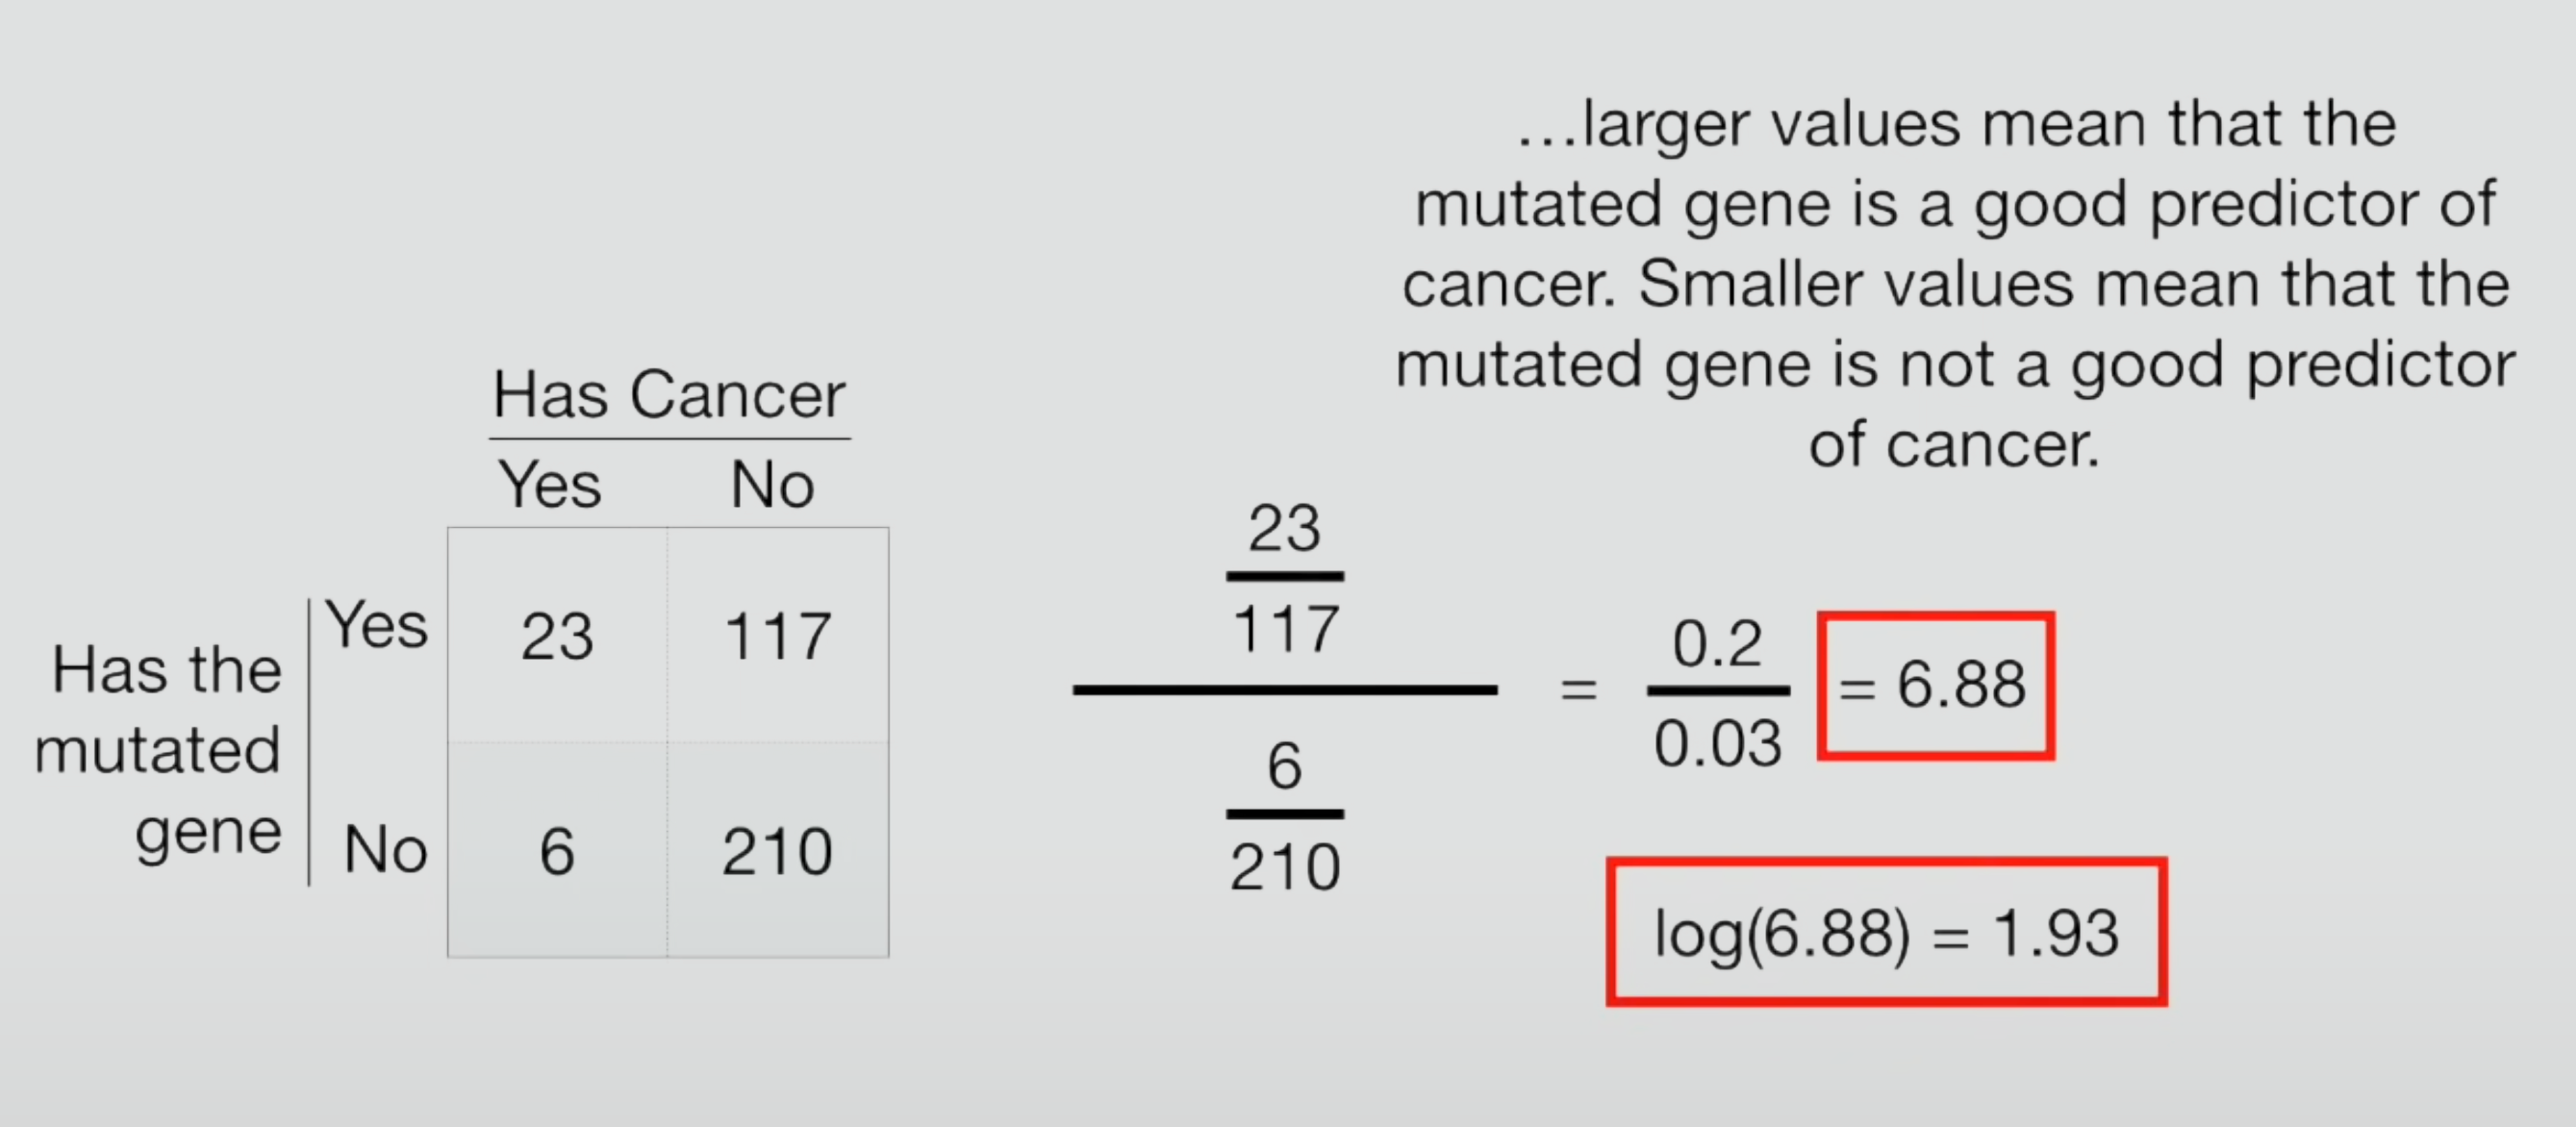

### Wald's test concept

$\mu = 0$

$st = \sqrt{\sum{1/n_i}}\text{, where } n_i \in [23,117,6,210]$

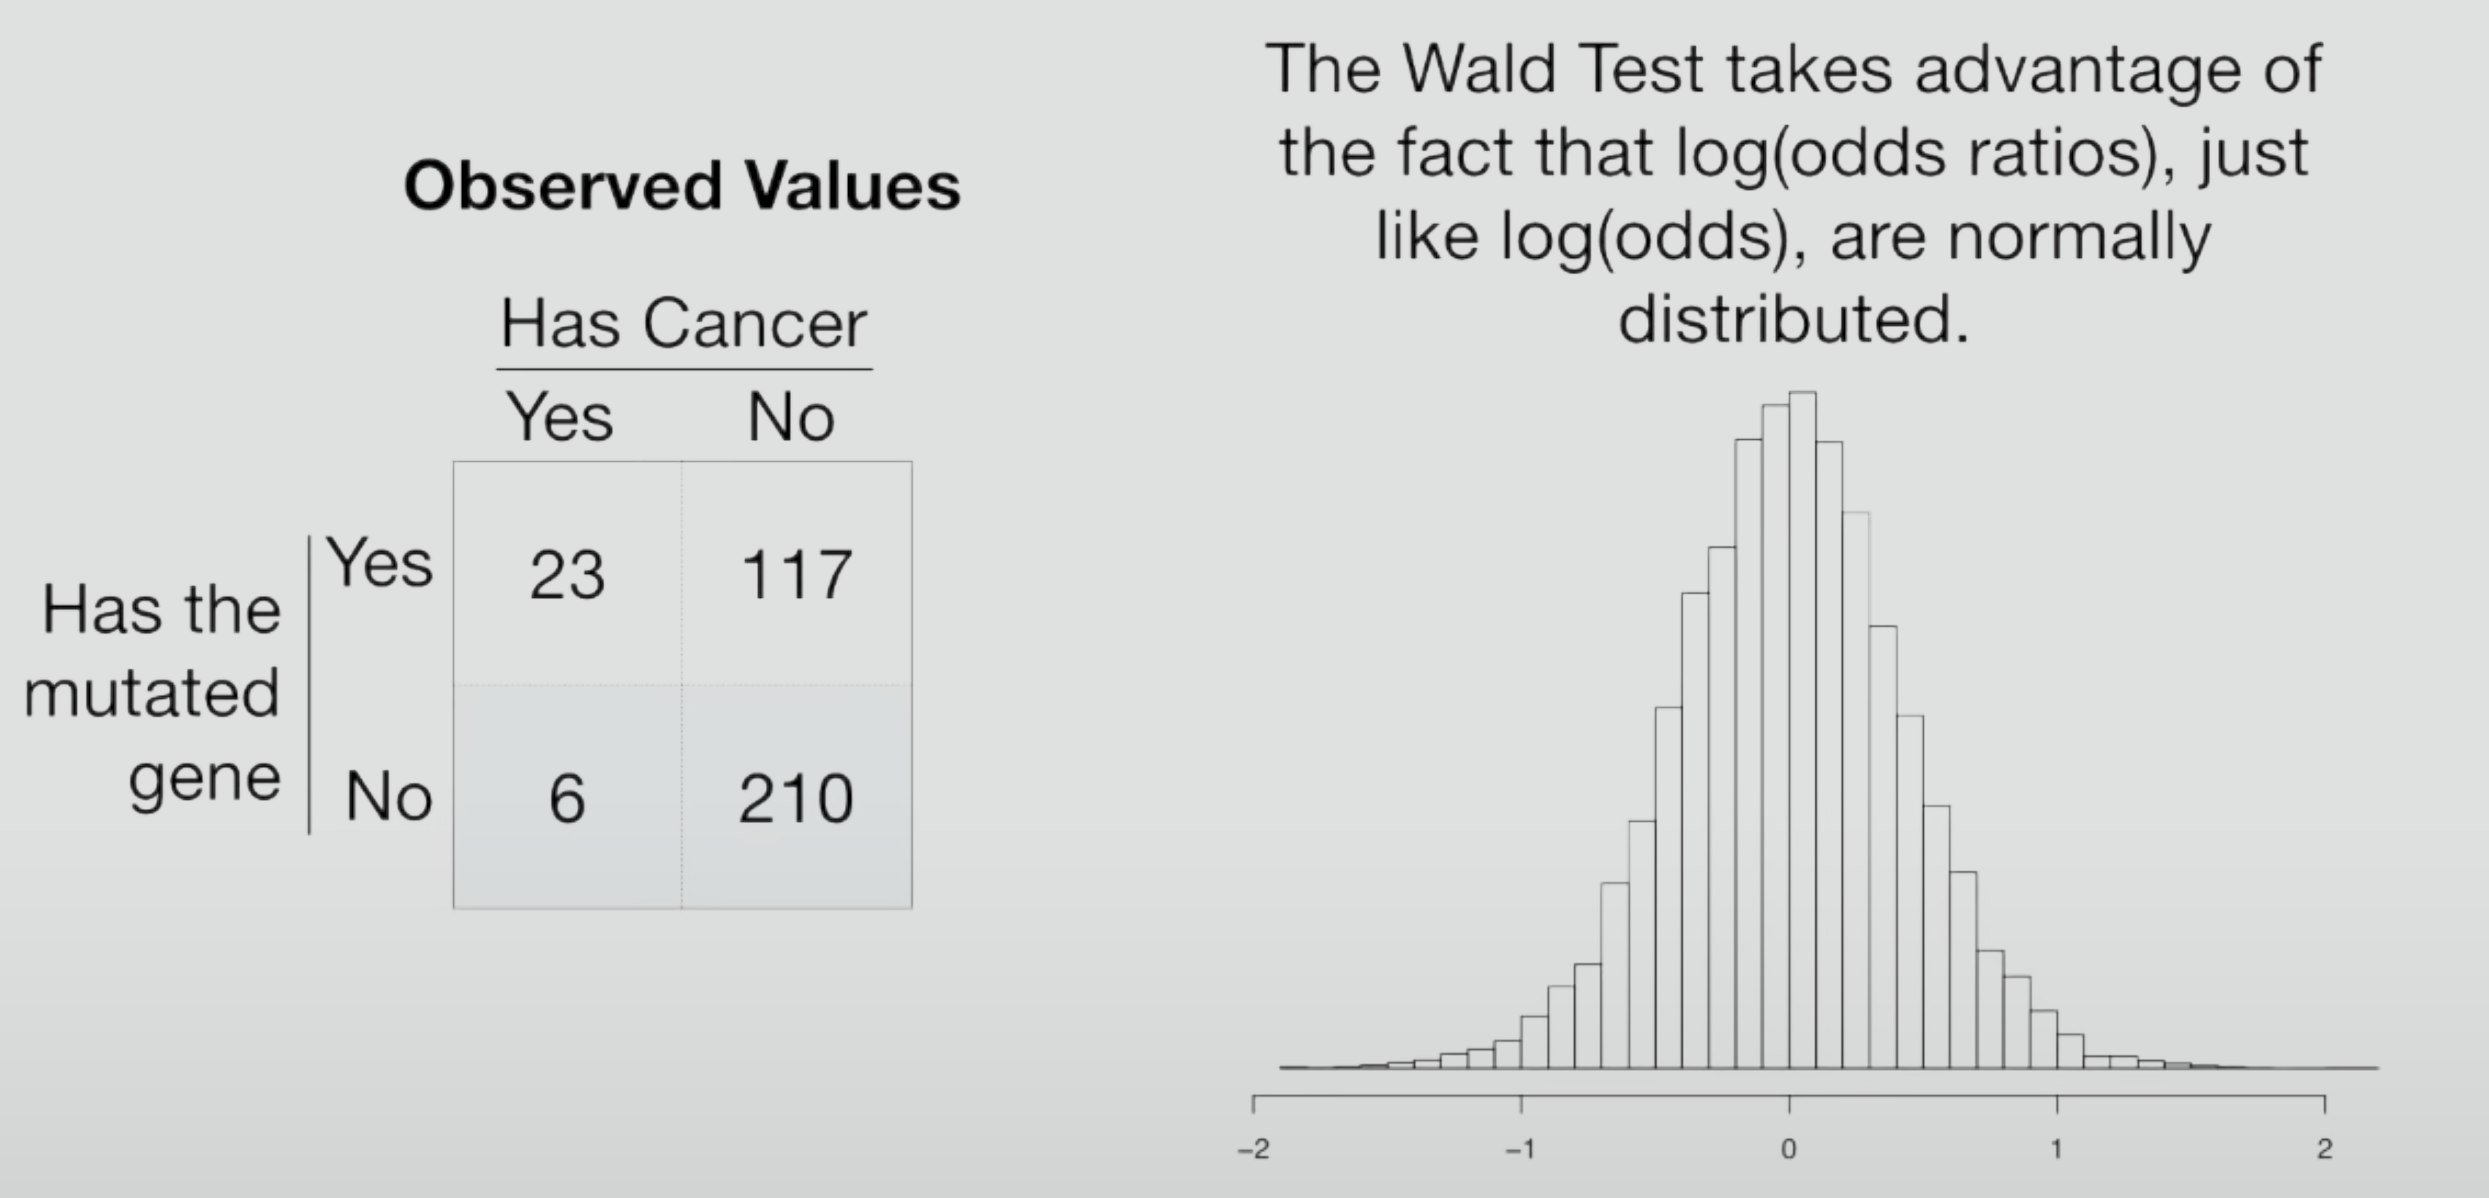

## Example 1. One variable, expected distribution

In [1]:
def chi_test(arr_observed, arr_expected, d_of_f):
    chi_stat = sum((arr_observed - arr_expected)**2 / arr_expected)
    CHI2 = ss.chi2(df=d_of_f)
    pvalue = 1 - CHI2.cdf(chi_stat)
    return chi_stat, pvalue

### Coin

Expected data will be formed from Binomial distribution, where

$\mu = n * p$

n - number of Bernoulli experiments  
p - probability of success  

In [2]:
n = 60
n_heads = 40
n_tails = 20
BINOMIAL = ss.binom(n, 0.5)
mean = BINOMIAL.mean()
d_of_f = 1

data = pd.DataFrame(
    data={'observed':[n_tails, n_heads],
        'expected':[mean, mean]},
    index=['head','tail']
)
display(data)

chi_stat, pvalue = chi_test(data['observed'], data['expected'], d_of_f)
print(f'chi-statistic = {chi_stat}')
print(f'pvalue = {pvalue}')

,observed,expected
head,20,30.0
tail,40,30.0


chi-statistic = 6.666666666666667
pvalue = 0.009823274507519186


In [3]:
# same result with SciPy test:
chi_stat, pvalue = ss.chisquare(data['observed'], data['expected'])
print(f'chi-statistic = {chi_stat}')
print(f'pvalue = {pvalue}')

chi-statistic = 6.666666666666667
pvalue = 0.009823274507519235


In this case, instead of testing H0, we can just ask the question: 'What is the probability of getting 20 or less tails in 60 coin flips?'

$p(x = 20) = C_n^k * p^k * (1 - p)^{(n - k)}$  
$p(x \le 20) = p(x = 20) + p(x = 19) + ... + p(x = 1) + p(x = 0)$

In [4]:
1 - BINOMIAL.cdf(39)
# or
BINOMIAL.cdf(20)

0.00674464686559593

### Dice

In [5]:
a = 1
b = 6
n = 60 # n of experiments
d_of_f = 5

D_UNIFORM = ss.randint(a, b + 1) # one experiment
mean = D_UNIFORM.pmf(3) * n
print(f'mean {mean}')

data = pd.DataFrame(
    data={'observed':[10,10,10,10,5,15],
        'expected':[mean] * 6},
    index=['1','2','3','4','5','6']
)
display(data)

chi_stat, pvalue = chi_test(data['observed'], data['expected'], d_of_f)
print(f'chi-statistic = {chi_stat}')
print(f'pvalue = {pvalue}')

mean 10.0


,observed,expected
1,10,10.0
2,10,10.0
3,10,10.0
4,10,10.0
5,5,10.0
6,15,10.0


chi-statistic = 5.0
pvalue = 0.415880186995508


In [6]:
# same result with SciPy test:
chi_stat, pvalue = ss.chisquare(data['observed'], data['expected'])
print(f'chi-statistic = {chi_stat}')
print(f'pvalue = {pvalue}')

chi-statistic = 5.0
pvalue = 0.4158801869955079


## Example 2. Two or more categorical variables VS each other

### Sex VS Profession

Restraint for Chi-test: n for each expected cell should be bigger that 5

$expected[i] \ge 5$

In [7]:
np.random.seed(48)
BERNOULLI = ss.bernoulli(0.5)
n = 41
d_of_f = 1

# contingency table looks like:
df = pd.DataFrame({
    'sex':BERNOULLI.rvs(n),
    'education':BERNOULLI.rvs(n),
    'dummy':[1] * n
})
df['sex'] = np.where(df['sex']==0, 'male', 'female')
df['education'] = np.where(df['education']==0, 'math', 'biology')
df.drop('dummy', axis=1).head()

,sex,education
0,male,biology
1,female,biology
2,male,biology
3,male,math
4,female,math


In [8]:
data = pd.pivot_table(data=df, columns='sex',
                      index='education', values='dummy', aggfunc='count')
data.loc[:,'total'] = data.sum(axis=1)
data.loc['total',:] = data.sum()
data

sex,female,male,total
education,,,
biology,9.0,12.0,21.0
math,6.0,14.0,20.0
total,15.0,26.0,41.0


In [9]:
expected = data.copy()
for col in data.columns.drop('total'):
    for row in data.index.drop('total'):
        total1 = data.loc['total', col]
        total2 = data.loc[row, 'total']
        expected.loc[row, col] = total1 * total2 / data.loc['total', 'total']

expected

sex,female,male,total
education,,,
biology,7.682927,13.317073,21.0
math,7.317073,12.682927,20.0
total,15.000000,26.000000,41.0


In [10]:
data_flat = data.values[:-1, :-1].flatten()
print('Flatten data:')
print(data_flat)

expected_flat = expected.values[:-1, :-1].flatten()
print('Flatten expected:')
print(expected_flat)

Flatten data:
[ 9. 12.  6. 14.]
Flatten expected:
[ 7.68292683 13.31707317  7.31707317 12.68292683]


In [11]:
d_of_f = 1

chi_stat, pvalue = chi_test(data_flat, expected_flat, d_of_f)
print(f'chi-statistic = {chi_stat}')
print(f'pvalue = {pvalue}')

chi-statistic = 0.7298901098901098
pvalue = 0.39291881046956134


In [12]:
# same result with SciPy test:
# df = k - 1 - ddof
# ddof = k - 1 - df
d_of_f = 1

chi_stat, pvalue = ss.chisquare(data_flat, expected_flat, ddof=(4 - 1 - d_of_f))
print(f'chi-statistic = {chi_stat}')
print(f'pvalue = {pvalue}')

chi-statistic = 0.7298901098901098
pvalue = 0.39291881046956134


In [13]:
# or even simpler version:
data = pd.pivot_table(data=df, columns='sex',
                      index='education', values='dummy', aggfunc='count')
display(data)

chi_stat, pvalue, d_of_f, expected = ss.chi2_contingency(data, correction=False)
display(expected)
print(f'chi-statistic = {chi_stat}')
print(f'pvalue = {pvalue}')

sex,female,male
education,,
biology,9,12
math,6,14


array([[ 7.68292683, 13.31707317],
       [ 7.31707317, 12.68292683]])

chi-statistic = 0.7298901098901098
pvalue = 0.39291881046956134


In [14]:
# with Yates correction:
chi_stat, pvalue, d_of_f, expected = ss.chi2_contingency(data, correction=True)
print(f'chi-statistic = {chi_stat}')
print(f'pvalue = {pvalue}')

chi-statistic = 0.28090506715506713
pvalue = 0.5961086164332364


### Fisher's exact, Treatment 1 VS Treatment 2

In [15]:
data = pd.DataFrame()
data.loc['Treatment1', 'Healthy'] = 'a'
data.loc['Treatment1', 'Not healthy'] = 'b'
data.loc['Treatment1', 'Total'] = 'a + b'

data.loc['Treatment2', 'Healthy'] = 'c'
data.loc['Treatment2', 'Not healthy'] = 'd'
data.loc['Treatment2', 'Total'] = 'c + d'

data.loc['Total', 'Healthy'] = 'a + c'
data.loc['Total', 'Not healthy'] = 'b + d'
data.loc['Total', 'Total'] = 'n'
data

,Healthy,Not healthy,Total
Treatment1,a,b,a + b
Treatment2,c,d,c + d
Total,a + c,b + d,n


Fisher's exact method tries to answer the question: What is the probability of getting this or a bigger difference, if **the probability of getting 'a' healthy with total 'a + b' people with 'Treatment1'** is the same as **the probability of getting 'c' healthy with total 'c + d' people with 'Trearment2'**?

In other words, we need to calculate the probability of getting **such table or even more different** if the probability to heal with treatment 1 is equal to the probability to heal with treatment 2.

$H0: P(a | a + b ) = P(c | c + d) = P$  
$H1: P(a | a + b ) \neq P(c | c + d)$

If 'a' and 'c' - numbers of healthy people, than:

$pvalue = \sum_{i}^{}\frac{C_{a+b}^a*C_{c+d}^c}{C_n^{a+c}}$

for all $[1...i]$ contingency tables that are same or more different with the given one

The formula can be derived using conditional probability rules or using classical probability interpretation

In [16]:
data = pd.DataFrame()
data.loc['Treatment1', 'Healthy'] = 3
data.loc['Treatment2', 'Healthy'] = 1
data.loc['Treatment1', 'Not healthy'] = 1
data.loc['Treatment2', 'Not healthy'] = 3

data.loc[:,'total'] = data.sum(axis=1)
data.loc['total',:] = data.sum()
data

,Healthy,Not healthy,total
Treatment1,3.0,1.0,4.0
Treatment2,1.0,3.0,4.0
total,4.0,4.0,8.0


In [17]:
stat, pvalue = ss.fisher_exact(data.values[:-1, :-1])
print(f'statistic = {stat}')
print(f'pvalue = {pvalue}')

statistic = 9.0
pvalue = 0.48571428571428565
